We are making clusters out of the embedded data. These clusters represent the data of each individual for categorization purposes

In [1]:
from utils import save_face_list, extract_frames
from face_extraction import process_image, check_face
from facenet_pytorch import MTCNN
import torch
import cv2
from main_unsupervised import find_best_number_of_clusters
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os
import shutil
import plots
import augmentation
import main_embed
import cluster_dataframe
import embed



In [2]:
MOVIE_TRAINING_LIST = ['New Kids ABC','New Kids Fussballspiel','New Kids Turbo_ Tankstation','New Kids Nitro, _Peter lemonade!_ 720']
MOVIE_TEST_LIST = ['Test']
MOVIE_FOLDER = "C:\\Users\\ningw\\Desktop\\"

FACES_FOLDER_TRAINING = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder\\'
FACES_FOLDER_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder_test\\'

OUTPUT_FOLDER_RESULTS_TRAIN = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results\\'
RESULTS_NAME_TRAIN = 'second_results.csv'
RESULTS_CSV_TRAIN = 'results\\second_results.csv'

OUTPUT_FOLDER_RESULTS_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\'
RESULTS_NAME_TEST = 'test_results.csv'
RESULTS_CSV_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\test_results.csv'

KMEANS_OUTPUT_FOLDER = 'KMEANS_OUTPUT'
CLUSTER_MODEL_PATH = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\KMEANS_OUTPUT\\kmeans.pkl'

directories = [MOVIE_FOLDER,FACES_FOLDER_TRAINING,FACES_FOLDER_TEST,OUTPUT_FOLDER_RESULTS_TRAIN,OUTPUT_FOLDER_RESULTS_TEST,KMEANS_OUTPUT_FOLDER]
for path in directories:
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)
        print(f"Checked/Created directory: {path}")
    else: 
        print(f"Directory already exists: {path}")


Directory already exists: Desktop
Directory already exists: face_folder
Directory already exists: face_folder_test
Directory already exists: results
Directory already exists: results_test
Directory already exists: KMEANS_OUTPUT


In [ ]:

cap = cv2.VideoCapture(MOVIE_FOLDER+MOVIE_TRAINING_LIST[1]+'.mp4')
if not cap.isOpened():
    print("Error: Cannot open video file.")
else:
    print("Video file opened successfully!")
cap.release()


In [ ]:
output_extension= '.png'
input_extension = '.mp4'
samples_per_second = 10         #FPS rate is assumed 25
padding_x = 10
padding_y = 10
min_confidence = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

for movie in MOVIE_TRAINING_LIST:
  print(movie+input_extension)
  frame_list = extract_frames(MOVIE_FOLDER,movie+input_extension,samples_per_second)
  face_list_movie = []
  for frame in frame_list:
    face_list_frame = process_image(frame,padding_x,padding_y,min_confidence)
    for face in face_list_frame:
      if check_face(face,mtcnn):
        face_list_movie.append(face)
  print('saving')
  save_face_list(face_list_movie,FACES_FOLDER_TRAINING,movie,output_extension)

In [ ]:
main_embed.embed(FACES_FOLDER_TRAINING, OUTPUT_FOLDER_RESULTS_TRAIN,RESULTS_NAME_TRAIN)


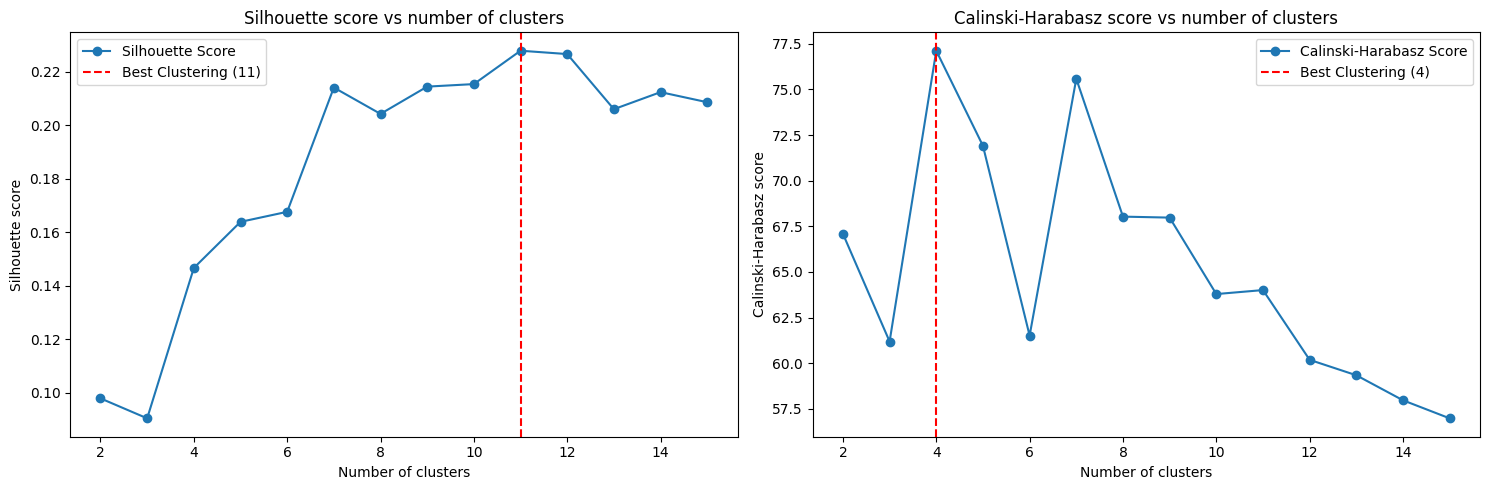

In [3]:
best_clusters_silhouette, best_clusters_calinski = find_best_number_of_clusters(RESULTS_CSV_TRAIN)
cluster_choice = best_clusters_calinski


In [ ]:
for movie in MOVIE_TEST_LIST:
  print(movie+input_extension)
  frame_list = extract_frames(MOVIE_FOLDER,movie+input_extension,samples_per_second)
  face_list_movie = []
  for frame in frame_list:
    face_list_frame = process_image(frame,padding_x,padding_y,min_confidence)
    for face in face_list_frame:
      if check_face(face,mtcnn):
        face_list_movie.append(face)
  print('saving')
  save_face_list(face_list_movie,FACES_FOLDER_TEST,movie,output_extension)

In [ ]:
main_embed.embed(FACES_FOLDER_TEST,OUTPUT_FOLDER_RESULTS_TEST,RESULTS_NAME_TEST)


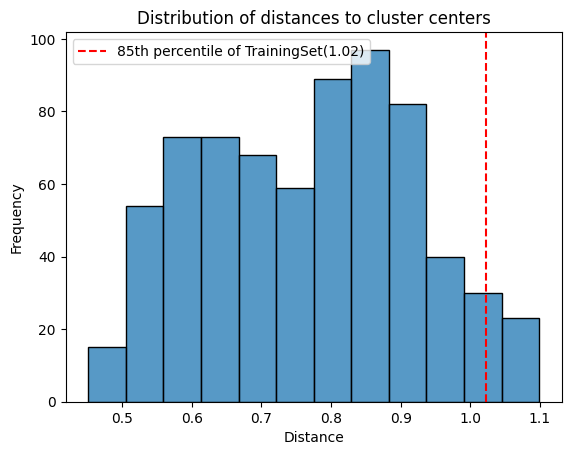

In [4]:

train_embeddings_df = pd.read_csv(RESULTS_CSV_TRAIN)
trains_embeddings = train_embeddings_df.T.values
test_embeddings_df = pd.read_csv(RESULTS_CSV_TEST)
test_embeddings = test_embeddings_df.T.values

kmeans = KMeans(random_state=0, n_clusters=cluster_choice).fit(trains_embeddings)
labels = kmeans.labels_

distances_train = pairwise_distances_argmin_min(trains_embeddings, kmeans.cluster_centers_)[1]
threshold_distance_85 = np.percentile(distances_train, 95)

plots.plot_histplot_percentile(distances_train, threshold_distance_85)

for i, file_name in enumerate(train_embeddings_df.columns):
    if distances_train[i] > threshold_distance_85:
        train_embeddings_df.drop(file_name, axis='columns', inplace=True)
    
trains_embeddings = train_embeddings_df.T.values
kmeans = KMeans(random_state=0, n_clusters=cluster_choice, max_iter=600).fit(trains_embeddings)
labels = kmeans.labels_

for i, file_name in enumerate(train_embeddings_df.columns):
    src_path = os.path.join(FACES_FOLDER_TRAINING, file_name)
    if distances_train[i] > threshold_distance_85:
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, 'outliers', file_name)
    else:   
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, f'cluster_{labels[i]}', file_name)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)
    


In [ ]:
clusterdf = cluster_dataframe.process_videos_to_dataframe(MOVIE_TEST_LIST,MOVIE_FOLDER,kmeans, threshold_distance_85=threshold_distance_85)
plots.plot_cluster_presence(clusterdf.sort_index(ascending=False)) 


In [ ]:
#Maakt de augmentations
augmentation.process_images_with_augmentations(FACES_FOLDER_TEST,'AUGMENTED')


In [ ]:
#Maakt van iedere folder met augmentation nieuwe embeddings
for folder_name in os.listdir('AUGMENTED'):
    folder_path = os.path.join('AUGMENTED', folder_name,'')
    if os.path.isdir(folder_path):
        # Dynamically construct paths
        AUGMENTED_FOLDERS = folder_path
        RESULT_NAME_TRAIN = f'embed_{folder_name}.csv'

        # Print paths for debugging
        print(f"Processing folder: {AUGMENTED_FOLDERS}")
        print(f"Output folder: {OUTPUT_FOLDER_RESULTS_TEST}")
        print(f"Result file: {RESULT_NAME_TRAIN}")

        # Call embedding function (example)
        main_embed.embed(AUGMENTED_FOLDERS, OUTPUT_FOLDER_RESULTS_TEST, RESULT_NAME_TRAIN)


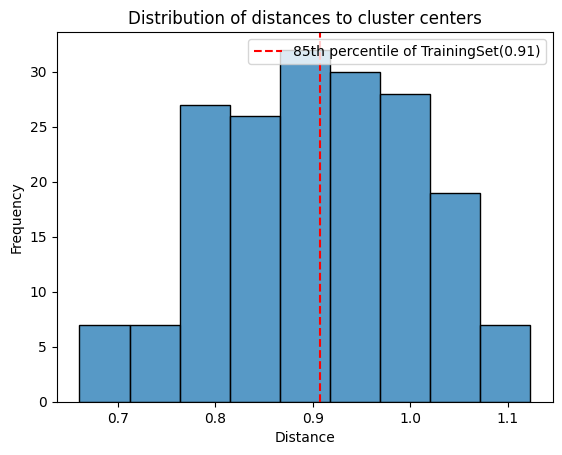

Image face_folder_testTest_148.png belongs to Cluster -1
Image face_folder_testTest_160.png belongs to Cluster 2
Image face_folder_testTest_174.png belongs to Cluster 1
Image face_folder_testTest_12.png belongs to Cluster -1
Image face_folder_testTest_175.png belongs to Cluster 1
Image face_folder_testTest_13.png belongs to Cluster -1
Image face_folder_testTest_161.png belongs to Cluster 2
Image face_folder_testTest_149.png belongs to Cluster -1
Image face_folder_testTest_39.png belongs to Cluster 1
Image face_folder_testTest_11.png belongs to Cluster -1
Image face_folder_testTest_177.png belongs to Cluster -1
Image face_folder_testTest_163.png belongs to Cluster -1
Image face_folder_testTest_162.png belongs to Cluster 2
Image face_folder_testTest_10.png belongs to Cluster -1
Image face_folder_testTest_176.png belongs to Cluster -1
Image face_folder_testTest_38.png belongs to Cluster -1
Image face_folder_testTest_172.png belongs to Cluster 1
Image face_folder_testTest_14.png belongs to

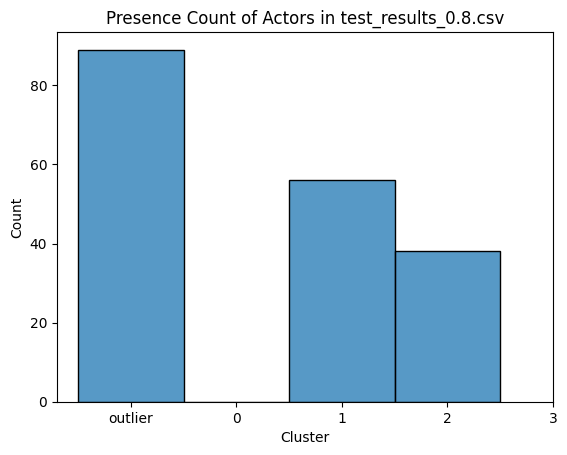

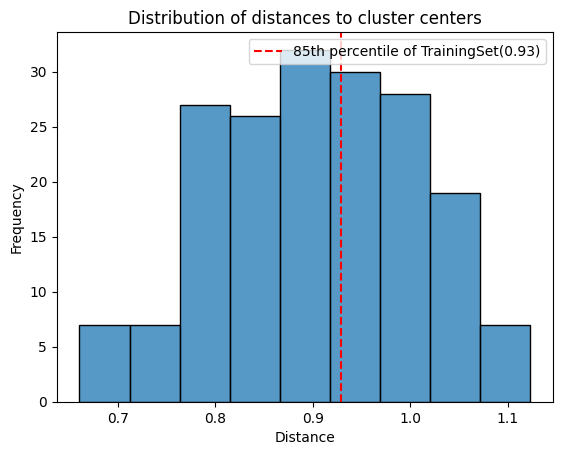

Image face_folder_testTest_148.png belongs to Cluster 2
Image face_folder_testTest_160.png belongs to Cluster 2
Image face_folder_testTest_174.png belongs to Cluster 1
Image face_folder_testTest_12.png belongs to Cluster -1
Image face_folder_testTest_175.png belongs to Cluster 1
Image face_folder_testTest_13.png belongs to Cluster -1
Image face_folder_testTest_161.png belongs to Cluster 2
Image face_folder_testTest_149.png belongs to Cluster -1
Image face_folder_testTest_39.png belongs to Cluster 1
Image face_folder_testTest_11.png belongs to Cluster -1
Image face_folder_testTest_177.png belongs to Cluster -1
Image face_folder_testTest_163.png belongs to Cluster -1
Image face_folder_testTest_162.png belongs to Cluster 2
Image face_folder_testTest_10.png belongs to Cluster -1
Image face_folder_testTest_176.png belongs to Cluster -1
Image face_folder_testTest_38.png belongs to Cluster -1
Image face_folder_testTest_172.png belongs to Cluster 1
Image face_folder_testTest_14.png belongs to 

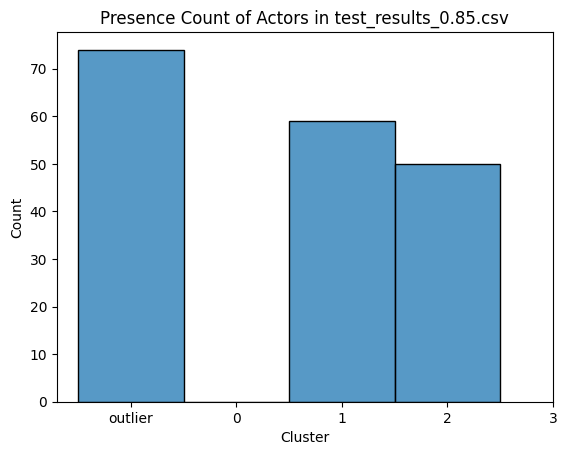

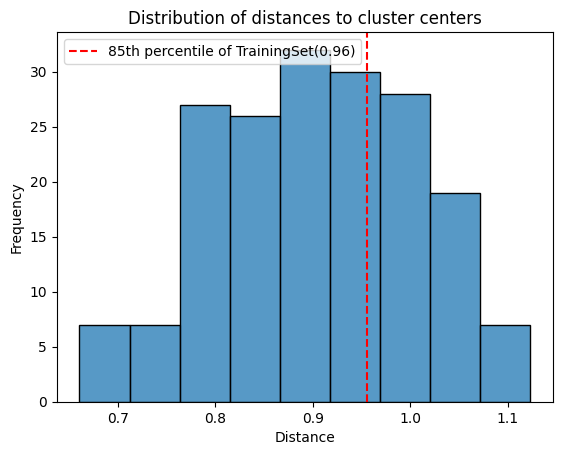

Image face_folder_testTest_148.png belongs to Cluster 2
Image face_folder_testTest_160.png belongs to Cluster 2
Image face_folder_testTest_174.png belongs to Cluster 1
Image face_folder_testTest_12.png belongs to Cluster -1
Image face_folder_testTest_175.png belongs to Cluster 1
Image face_folder_testTest_13.png belongs to Cluster -1
Image face_folder_testTest_161.png belongs to Cluster 2
Image face_folder_testTest_149.png belongs to Cluster -1
Image face_folder_testTest_39.png belongs to Cluster 1
Image face_folder_testTest_11.png belongs to Cluster -1
Image face_folder_testTest_177.png belongs to Cluster 2
Image face_folder_testTest_163.png belongs to Cluster -1
Image face_folder_testTest_162.png belongs to Cluster 2
Image face_folder_testTest_10.png belongs to Cluster -1
Image face_folder_testTest_176.png belongs to Cluster -1
Image face_folder_testTest_38.png belongs to Cluster -1
Image face_folder_testTest_172.png belongs to Cluster 1
Image face_folder_testTest_14.png belongs to C

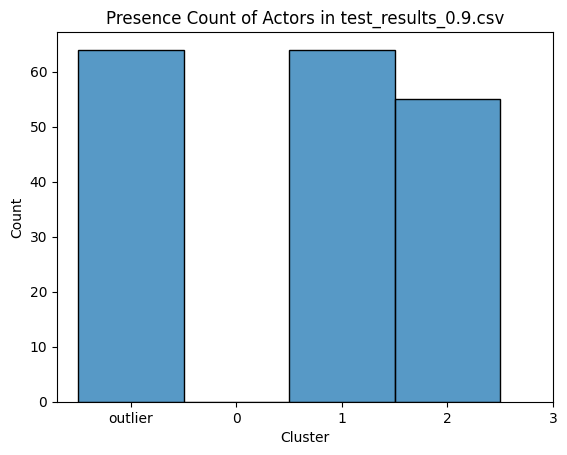

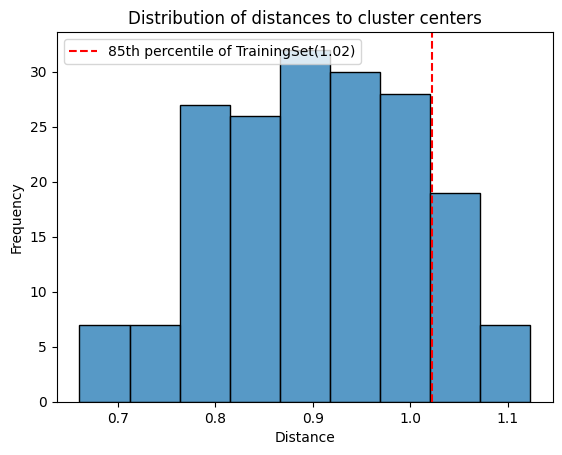

Image face_folder_testTest_148.png belongs to Cluster 2
Image face_folder_testTest_160.png belongs to Cluster 2
Image face_folder_testTest_174.png belongs to Cluster 1
Image face_folder_testTest_12.png belongs to Cluster -1
Image face_folder_testTest_175.png belongs to Cluster 1
Image face_folder_testTest_13.png belongs to Cluster 1
Image face_folder_testTest_161.png belongs to Cluster 2
Image face_folder_testTest_149.png belongs to Cluster -1
Image face_folder_testTest_39.png belongs to Cluster 1
Image face_folder_testTest_11.png belongs to Cluster -1
Image face_folder_testTest_177.png belongs to Cluster 2
Image face_folder_testTest_163.png belongs to Cluster 2
Image face_folder_testTest_162.png belongs to Cluster 2
Image face_folder_testTest_10.png belongs to Cluster 1
Image face_folder_testTest_176.png belongs to Cluster 1
Image face_folder_testTest_38.png belongs to Cluster 2
Image face_folder_testTest_172.png belongs to Cluster 1
Image face_folder_testTest_14.png belongs to Cluste

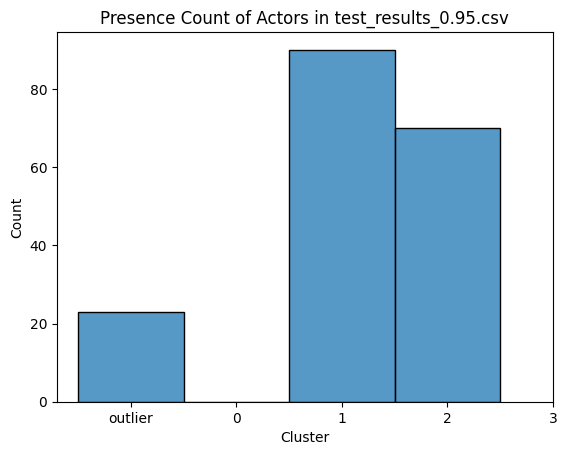

In [5]:
thresholds = [0.80, 0.85, 0.9, 0.95]
for threshold in thresholds:
    # Calculate the threshold distance for the current percentile
    threshold_distance = np.percentile(distances_train, threshold * 100)
    
    # Process the test embeddings with the current threshold
    results_df = cluster_dataframe.process_test_embeddings(
        test_embeddings=test_embeddings,
        test_embeddings_df=test_embeddings_df,
        kmeans=kmeans,
        output_folder='recognition-output',
        face_folder_test='face_folder_test',
        threshold=threshold_distance,
        results_output_path = f'test_results_{threshold}.csv',
        
    )
    
    # Plot actor presence
    plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,f'test_results_{threshold}.csv')


Processing file: results_testembed_distortion.csv
Index(['face_folder_testTest_110_distortion.jpg',
       'face_folder_testTest_105_distortion.jpg',
       'face_folder_testTest_91_distortion.jpg',
       'face_folder_testTest_84_distortion.jpg',
       'face_folder_testTest_174_distortion.jpg',
       'face_folder_testTest_161_distortion.jpg',
       'face_folder_testTest_169_distortion.jpg',
       'face_folder_testTest_66_distortion.jpg',
       'face_folder_testTest_73_distortion.jpg',
       'face_folder_testTest_99_distortion.jpg',
       ...
       'face_folder_testTest_124_distortion.jpg',
       'face_folder_testTest_131_distortion.jpg',
       'face_folder_testTest_140_distortion.jpg',
       'face_folder_testTest_155_distortion.jpg',
       'face_folder_testTest_148_distortion.jpg',
       'face_folder_testTest_52_distortion.jpg',
       'face_folder_testTest_47_distortion.jpg',
       'face_folder_testTest_36_distortion.jpg',
       'face_folder_testTest_23_distortion.jpg'

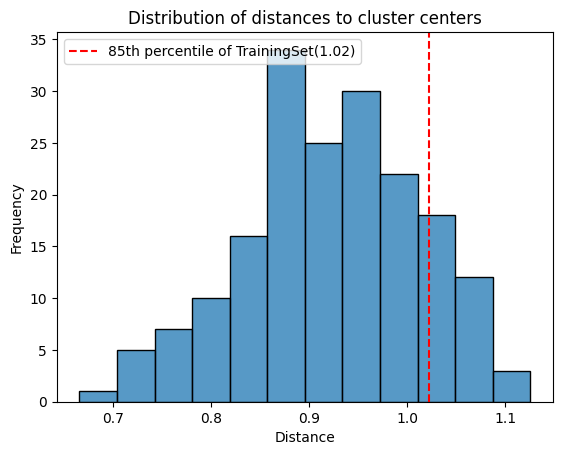

Image face_folder_testTest_110_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_105_distortion.jpg belongs to Cluster 1
Image face_folder_testTest_91_distortion.jpg belongs to Cluster 1
Image face_folder_testTest_84_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_174_distortion.jpg belongs to Cluster 1
Image face_folder_testTest_161_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_169_distortion.jpg belongs to Cluster -1
Image face_folder_testTest_66_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_73_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_99_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_17_distortion.jpg belongs to Cluster -1
Image face_folder_testTest_118_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_83_distortion.jpg belongs to Cluster 1
Image face_folder_testTest_96_distortion.jpg belongs to Cluster 2
Image face_folder_testTest_102_distortion.jpg belongs to Cluster 2
I

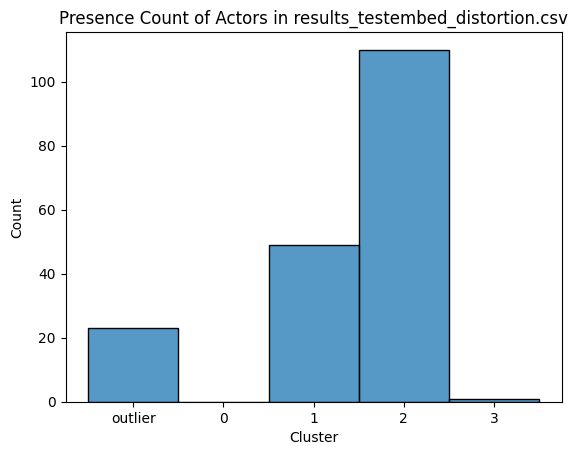

Processing file: results_testembed_brightness_contrast.csv
Index(['face_folder_testTest_165_brightness_contrast.jpg',
       'face_folder_testTest_74_brightness_contrast.jpg',
       'face_folder_testTest_8_brightness_contrast.jpg',
       'face_folder_testTest_114_brightness_contrast.jpg',
       'face_folder_testTest_99_brightness_contrast.jpg',
       'face_folder_testTest_125_brightness_contrast.jpg',
       'face_folder_testTest_96_brightness_contrast.jpg',
       'face_folder_testTest_7_brightness_contrast.jpg',
       'face_folder_testTest_34_brightness_contrast.jpg',
       'face_folder_testTest_154_brightness_contrast.jpg',
       ...
       'face_folder_testTest_90_brightness_contrast.jpg',
       'face_folder_testTest_21_brightness_contrast.jpg',
       'face_folder_testTest_83_brightness_contrast.jpg',
       'face_folder_testTest_130_brightness_contrast.jpg',
       'face_folder_testTest_50_brightness_contrast.jpg',
       'face_folder_testTest_141_brightness_contrast.jpg'

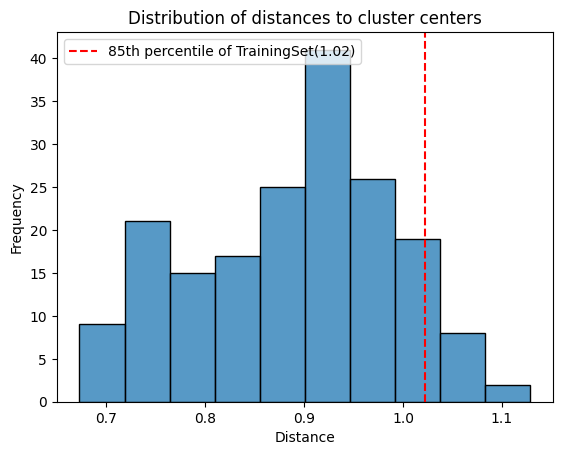

Image face_folder_testTest_165_brightness_contrast.jpg belongs to Cluster 2
Image face_folder_testTest_74_brightness_contrast.jpg belongs to Cluster 2
Image face_folder_testTest_8_brightness_contrast.jpg belongs to Cluster -1
Image face_folder_testTest_114_brightness_contrast.jpg belongs to Cluster -1
Image face_folder_testTest_99_brightness_contrast.jpg belongs to Cluster 2
Image face_folder_testTest_125_brightness_contrast.jpg belongs to Cluster 1
Image face_folder_testTest_96_brightness_contrast.jpg belongs to Cluster 2
Image face_folder_testTest_7_brightness_contrast.jpg belongs to Cluster 1
Image face_folder_testTest_34_brightness_contrast.jpg belongs to Cluster 2
Image face_folder_testTest_154_brightness_contrast.jpg belongs to Cluster 1
Image face_folder_testTest_45_brightness_contrast.jpg belongs to Cluster 1
Image face_folder_testTest_68_brightness_contrast.jpg belongs to Cluster 1
Image face_folder_testTest_147_brightness_contrast.jpg belongs to Cluster 1
Image face_folder_te

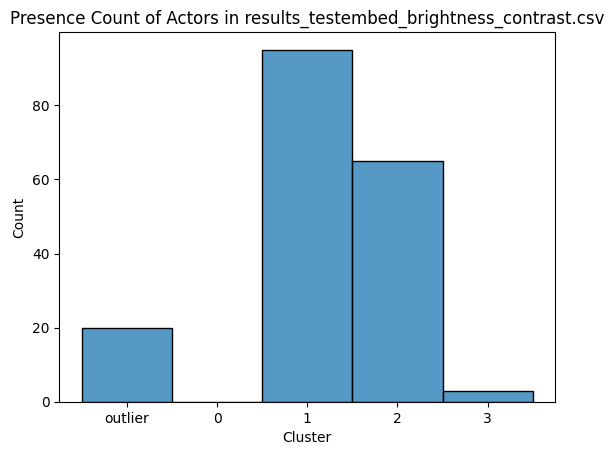

Processing file: results_testembed_cutout.csv
Index(['face_folder_testTest_49_cutout.jpg',
       'face_folder_testTest_174_cutout.jpg',
       'face_folder_testTest_143_cutout.jpg',
       'face_folder_testTest_116_cutout.jpg',
       'face_folder_testTest_121_cutout.jpg',
       'face_folder_testTest_81_cutout.jpg',
       'face_folder_testTest_62_cutout.jpg',
       'face_folder_testTest_55_cutout.jpg',
       'face_folder_testTest_37_cutout.jpg',
       'face_folder_testTest_168_cutout.jpg',
       ...
       'face_folder_testTest_93_cutout.jpg',
       'face_folder_testTest_104_cutout.jpg',
       'face_folder_testTest_133_cutout.jpg',
       'face_folder_testTest_166_cutout.jpg',
       'face_folder_testTest_151_cutout.jpg',
       'face_folder_testTest_12_cutout.jpg',
       'face_folder_testTest_25_cutout.jpg',
       'face_folder_testTest_70_cutout.jpg',
       'face_folder_testTest_47_cutout.jpg',
       'face_folder_testTest_118_cutout.jpg'],
      dtype='object', length=183

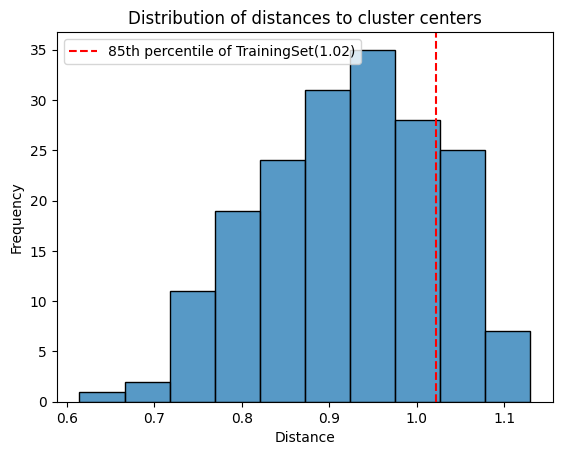

Image face_folder_testTest_49_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_174_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_143_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_116_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_121_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_81_cutout.jpg belongs to Cluster 2
Image face_folder_testTest_62_cutout.jpg belongs to Cluster 2
Image face_folder_testTest_55_cutout.jpg belongs to Cluster 2
Image face_folder_testTest_37_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_168_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_5_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_179_cutout.jpg belongs to Cluster 2
Image face_folder_testTest_26_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_11_cutout.jpg belongs to Cluster -1
Image face_folder_testTest_44_cutout.jpg belongs to Cluster 1
Image face_folder_testTest_73_cutout.jpg belongs to Cluster 2
Im

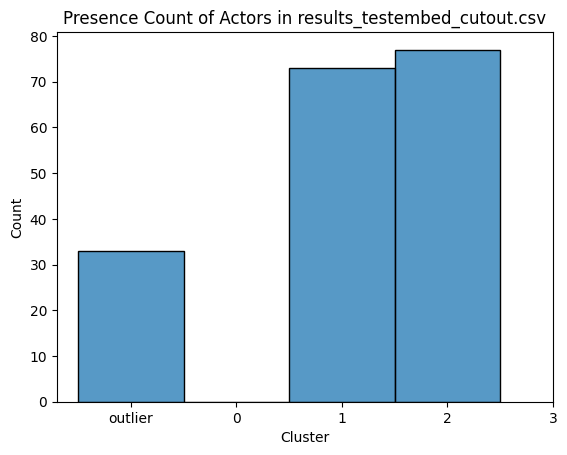

Processing file: results_testembed_rotation.csv
Index(['face_folder_testTest_108_rotation.jpg',
       'face_folder_testTest_56_rotation.jpg',
       'face_folder_testTest_51_rotation.jpg',
       'face_folder_testTest_44_rotation.jpg',
       'face_folder_testTest_11_rotation.jpg',
       'face_folder_testTest_43_rotation.jpg',
       'face_folder_testTest_16_rotation.jpg',
       'face_folder_testTest_148_rotation.jpg',
       'face_folder_testTest_181_rotation.jpg',
       'face_folder_testTest_75_rotation.jpg',
       ...
       'face_folder_testTest_70_rotation.jpg',
       'face_folder_testTest_129_rotation.jpg',
       'face_folder_testTest_22_rotation.jpg',
       'face_folder_testTest_77_rotation.jpg',
       'face_folder_testTest_88_rotation.jpg',
       'face_folder_testTest_37_rotation.jpg',
       'face_folder_testTest_62_rotation.jpg',
       'face_folder_testTest_169_rotation.jpg',
       'face_folder_testTest_30_rotation.jpg',
       'face_folder_testTest_65_rotation.jp

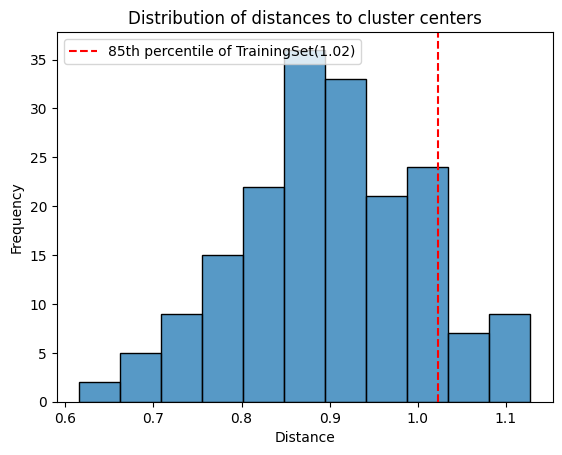

Image face_folder_testTest_108_rotation.jpg belongs to Cluster 1
Image face_folder_testTest_56_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_51_rotation.jpg belongs to Cluster 1
Image face_folder_testTest_44_rotation.jpg belongs to Cluster 1
Image face_folder_testTest_11_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_43_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_16_rotation.jpg belongs to Cluster -1
Image face_folder_testTest_148_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_181_rotation.jpg belongs to Cluster 1
Image face_folder_testTest_75_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_20_rotation.jpg belongs to Cluster 1
Image face_folder_testTest_179_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_72_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_27_rotation.jpg belongs to Cluster 2
Image face_folder_testTest_67_rotation.jpg belongs to Cluster 1
Image face_folder_testTest_32_rotat

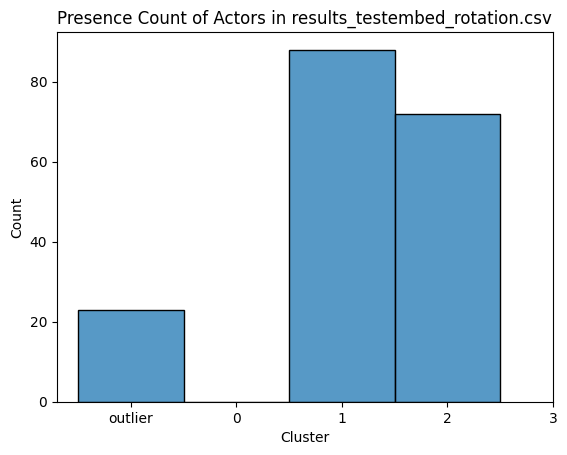

Processing file: test_results.csv
Index(['face_folder_testTest_148.png', 'face_folder_testTest_160.png',
       'face_folder_testTest_174.png', 'face_folder_testTest_12.png',
       'face_folder_testTest_175.png', 'face_folder_testTest_13.png',
       'face_folder_testTest_161.png', 'face_folder_testTest_149.png',
       'face_folder_testTest_39.png', 'face_folder_testTest_11.png',
       ...
       'face_folder_testTest_144.png', 'face_folder_testTest_22.png',
       'face_folder_testTest_36.png', 'face_folder_testTest_150.png',
       'face_folder_testTest_178.png', 'face_folder_testTest_179.png',
       'face_folder_testTest_37.png', 'face_folder_testTest_151.png',
       'face_folder_testTest_145.png', 'face_folder_testTest_23.png'],
      dtype='object', length=183)


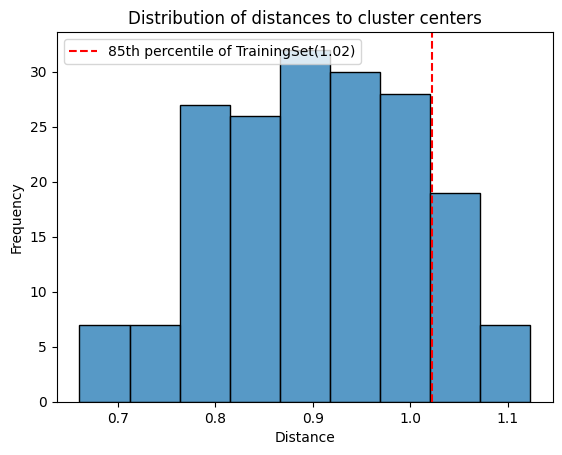

Image face_folder_testTest_148.png belongs to Cluster 2
Image face_folder_testTest_160.png belongs to Cluster 2
Image face_folder_testTest_174.png belongs to Cluster 1
Image face_folder_testTest_12.png belongs to Cluster -1
Image face_folder_testTest_175.png belongs to Cluster 1
Image face_folder_testTest_13.png belongs to Cluster 1
Image face_folder_testTest_161.png belongs to Cluster 2
Image face_folder_testTest_149.png belongs to Cluster -1
Image face_folder_testTest_39.png belongs to Cluster 1
Image face_folder_testTest_11.png belongs to Cluster -1
Image face_folder_testTest_177.png belongs to Cluster 2
Image face_folder_testTest_163.png belongs to Cluster 2
Image face_folder_testTest_162.png belongs to Cluster 2
Image face_folder_testTest_10.png belongs to Cluster 1
Image face_folder_testTest_176.png belongs to Cluster 1
Image face_folder_testTest_38.png belongs to Cluster 2
Image face_folder_testTest_172.png belongs to Cluster 1
Image face_folder_testTest_14.png belongs to Cluste

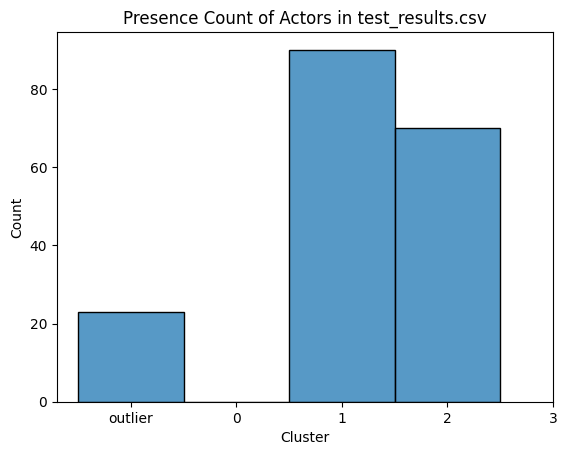

Processing file: results_testembed_horizontal_flip.csv
Index(['face_folder_testTest_159_horizontal_flip.jpg',
       'face_folder_testTest_58_horizontal_flip.jpg',
       'face_folder_testTest_108_horizontal_flip.jpg',
       'face_folder_testTest_10_horizontal_flip.jpg',
       'face_folder_testTest_140_horizontal_flip.jpg',
       'face_folder_testTest_41_horizontal_flip.jpg',
       'face_folder_testTest_111_horizontal_flip.jpg',
       'face_folder_testTest_158_horizontal_flip.jpg',
       'face_folder_testTest_109_horizontal_flip.jpg',
       'face_folder_testTest_59_horizontal_flip.jpg',
       ...
       'face_folder_testTest_169_horizontal_flip.jpg',
       'face_folder_testTest_39_horizontal_flip.jpg',
       'face_folder_testTest_138_horizontal_flip.jpg',
       'face_folder_testTest_68_horizontal_flip.jpg',
       'face_folder_testTest_82_horizontal_flip.jpg',
       'face_folder_testTest_170_horizontal_flip.jpg',
       'face_folder_testTest_20_horizontal_flip.jpg',
       

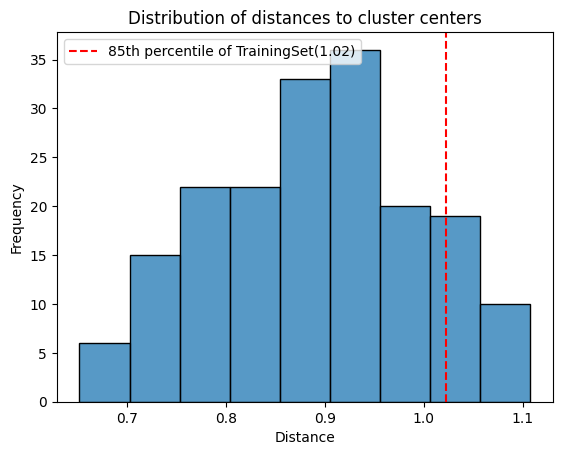

Image face_folder_testTest_159_horizontal_flip.jpg belongs to Cluster -1
Image face_folder_testTest_58_horizontal_flip.jpg belongs to Cluster 2
Image face_folder_testTest_108_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_10_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_140_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_41_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_111_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_158_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_109_horizontal_flip.jpg belongs to Cluster -1
Image face_folder_testTest_59_horizontal_flip.jpg belongs to Cluster 2
Image face_folder_testTest_141_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_11_horizontal_flip.jpg belongs to Cluster -1
Image face_folder_testTest_110_horizontal_flip.jpg belongs to Cluster 1
Image face_folder_testTest_40_horizontal_flip.jpg belongs to Clust

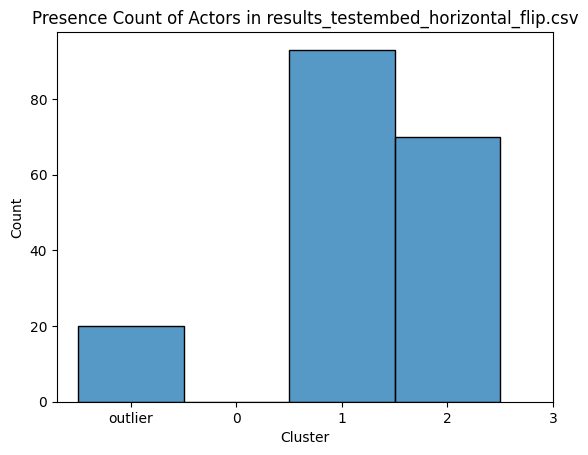

Processing file: results_testembed_gaussian_noise.csv
Index(['face_folder_testTest_54_gaussian_noise.jpg',
       'face_folder_testTest_37_gaussian_noise.jpg',
       'face_folder_testTest_59_gaussian_noise.jpg',
       'face_folder_testTest_92_gaussian_noise.jpg',
       'face_folder_testTest_166_gaussian_noise.jpg',
       'face_folder_testTest_105_gaussian_noise.jpg',
       'face_folder_testTest_108_gaussian_noise.jpg',
       'face_folder_testTest_82_gaussian_noise.jpg',
       'face_folder_testTest_49_gaussian_noise.jpg',
       'face_folder_testTest_27_gaussian_noise.jpg',
       ...
       'face_folder_testTest_65_gaussian_noise.jpg',
       'face_folder_testTest_68_gaussian_noise.jpg',
       'face_folder_testTest_0_gaussian_noise.jpg',
       'face_folder_testTest_181_gaussian_noise.jpg',
       'face_folder_testTest_129_gaussian_noise.jpg',
       'face_folder_testTest_124_gaussian_noise.jpg',
       'face_folder_testTest_147_gaussian_noise.jpg',
       'face_folder_testTest

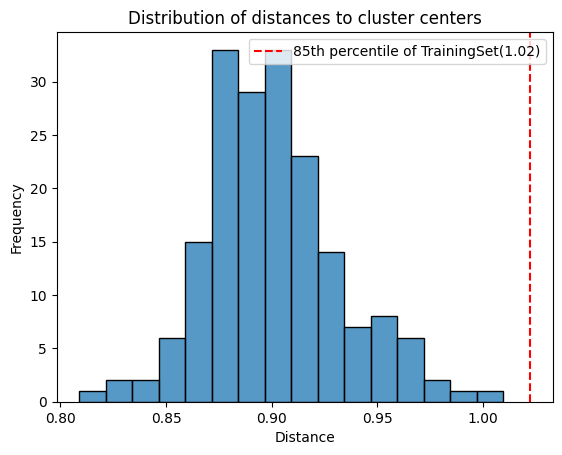

Image face_folder_testTest_54_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_37_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_59_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_92_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_166_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_105_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_108_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_82_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_49_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_27_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_44_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_118_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_115_gaussian_noise.jpg belongs to Cluster 2
Image face_folder_testTest_176_gaussian_noise.jpg belongs to Cluster 2
Image face_fol

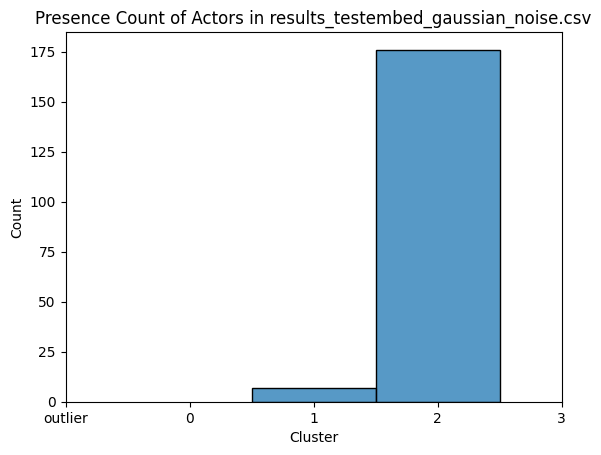

In [6]:
#voor ieder embeddingbestand wordt clusterin gedaan, afstand bepaald en frequenty gedemonstreerd clustering distance 85
for file_name in os.listdir(OUTPUT_FOLDER_RESULTS_TEST):
    file_path = os.path.join(OUTPUT_FOLDER_RESULTS_TEST, file_name)
    
    # Check if it's a CSV file
    if file_name.endswith('.csv') and os.path.isfile(file_path):
        print(f"Processing file: {file_name}")
        
        # Read the embeddings from the CSV file
        test_embeddings_df = pd.read_csv(file_path)
        test_embeddings = test_embeddings_df.T.values
        print(test_embeddings_df.columns)
        # Process the embeddings and generate results
        results_df = cluster_dataframe.process_test_embeddings(
            test_embeddings=test_embeddings,
            test_embeddings_df=test_embeddings_df,
            kmeans=kmeans,
            output_folder='recognition-output',
            face_folder_test='face_folder_test',
            threshold=threshold_distance_85,
            results_output_path = file_name,
            
            
        )
        
        # Plot actor presence
        plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,file_name)